# Big Movers

In [1]:
from IPython.display import clear_output, display, HTML
from urllib.parse import urlencode
from datetime import datetime, timedelta
from collections import defaultdict
import queue
import requests
import threading
import pandas as pd
import itertools
from math import isnan
import pytz
import json
import csv
import matplotlib.pyplot as plt
from matplotlib import style
from time import sleep
    
style.use('ggplot')

TOP_ITEMS_COUNT = 10
DATA_TIMEZONE = pytz.timezone("US/Eastern")
CLIENT_TIMEZONE = pytz.timezone('America/Los_Angeles')
periods = [1, 5, 15, 30, 60, "All day"]
now = datetime.now(tz=CLIENT_TIMEZONE)
weekday = now.isoweekday()
if weekday > 5:
    now = (now - timedelta(days=weekday - 5)).replace(hour=15)

In [2]:
def get_symbols():
    with open("n13_symbols.csv", "r") as f:
        symbols = f.read().split()
    return list(set(symbols))
symbols = get_symbols()
len(symbols)

3198

In [3]:
def get_minute_data(symbol, now):
    now = now.replace(second=0, microsecond=0)
    start = now.replace(hour=6, minute=30)
    if start > now:
        raise ValueError("It's too early")
    
    url = "https://query1.finance.yahoo.com/v7/finance/chart/{}?period1={:.0f}&period2={:.0f}"\
          "&interval=1m&indicators=quote&includeTimestamps=true&"\
          "events=div%7Csplit%7Cearn".format(symbol, start.timestamp(), now.timestamp())
    
    try:
        page = requests.get(url)
    except Exception as e:
        print("Exception while getiing {}".format(symbol), e)
        return
    else:
        result = page.json()['chart']['result']
        if not result:
            print(symbol, page.json())
            return
        data = result[0]
        quote = data['indicators']['quote'][0]
        if 'timestamp' not in data:
            return
        times = data['timestamp']
        period = data['meta']['currentTradingPeriod']['regular']
        start, end = period['start'], period['end']
        df = pd.Series(quote.get('close'), index=[datetime.fromtimestamp(t, tz=DATA_TIMEZONE).astimezone(now.tzinfo) for t in times])
        return df

minute_data = get_minute_data('SRCE', now) # SRCE
minute_data[:10]

2018-04-27 06:30:00-07:00    53.07
2018-04-27 06:31:00-07:00      NaN
2018-04-27 06:32:00-07:00      NaN
2018-04-27 06:33:00-07:00      NaN
2018-04-27 06:34:00-07:00      NaN
2018-04-27 06:35:00-07:00      NaN
2018-04-27 06:36:00-07:00      NaN
2018-04-27 06:37:00-07:00      NaN
2018-04-27 06:38:00-07:00      NaN
2018-04-27 06:39:00-07:00      NaN
dtype: float64

In [4]:
def get_period_change(series, period):
    """
    2017-06-02 09:48:00-07:00          NaN
    2017-06-02 09:49:00-07:00    46.834999
    2017-06-02 09:50:00-07:00          NaN
    2017-06-02 09:51:00-07:00          NaN
    2017-06-02 09:52:00-07:00          NaN
    2017-06-02 09:53:00-07:00          NaN
    2017-06-02 09:54:00-07:00          NaN
    2017-06-02 09:55:00-07:00          NaN
    2017-06-02 09:56:00-07:00    46.770000
    """
    start_value = end_value = change = None
    if type(period) is int:
        # get the latest valid value from the previous period
        prev_series = series[:-period]
        li = prev_series.last_valid_index()
        if li:
            start_value = prev_series[li]
            
        period_series = series[-period:]
        li = period_series.last_valid_index()
        if li:
            end_value = period_series[li]
    else:
        fi = series.first_valid_index()
        if fi:
            start_value = series[fi]   
    
        li = series.last_valid_index()
        if li:
            end_value = series[li]
    if None not in (start_value, end_value):
        change = (end_value / start_value - 1) * 100
    return change
    
get_period_change(minute_data, 5)

-0.09455226182037979

In [5]:
def load_data(symbols, time):
    
    num_worker_threads = 100
    
    def worker():
        while True:
            symbol = q.get()
            if symbol is None:
                break
            
            # GET DATA
            data = get_minute_data(symbol, time)
            if data is not None:
                r.put((symbol, data))
            
            q.task_done()

    q = queue.Queue() # queue with arguments for the 'get_transactions' function
    r = queue.Queue() # queue with raw responses

    threads = []
    for i in range(num_worker_threads):
        t = threading.Thread(target=worker)
        t.start()
        threads.append(t)

    for symbol in symbols:
        q.put(symbol)

    # block until all tasks are done
    q.join()

    # stop workers
    for i in range(num_worker_threads):
        q.put(None)

    for t in threads:
        t.join()
    
    # get and save data
    period_changes = defaultdict(list)
    minute_data = {}    
    symbols_saved = []
    while True:
        try:
            symbol, data = r.get(block=False)
        except queue.Empty:
            break
        else:
            symbols_saved.append(symbol)
            minute_data[symbol] = data
            for p in periods:
                period_changes[p].append(get_period_change(data, p))
                
    period_changes = pd.DataFrame(period_changes, index=symbols_saved)
    
    return period_changes, minute_data

r, e = load_data(("SRCE", "GOOG"), now)
r

,1,5,All day,60,30,15
SRCE,0.075738,-0.056737,-0.414549,-0.283022,-0.075630,-0.188862
GOOG,-0.049153,-0.046241,-1.451879,0.156795,0.313892,0.033345


,1,5,15,30,60,All day
0,JSYNR 5.38%,STLRW 9.76%,CYHHZ 29.27%,CYRXW 33.25%,CYRXW 33.25%,RTNB 45.00%
1,ASTC 4.65%,SSNT 9.02%,JSYNR 16.99%,CYHHZ 29.27%,CYHHZ 29.27%,BHACR 35.55%
2,NICK 4.17%,JSYNR 5.38%,STLRW 9.76%,ZXZZT 27.95%,ZXZZT 27.95%,CYRXW 33.63%
3,SCKT 3.88%,ARGS 5.36%,SSNT 9.02%,NAUH 10.64%,CHEK 15.33%,CYHHZ 29.27%
4,PBHC 3.47%,ASTC 5.31%,AAME 6.56%,STLRW 9.76%,VKTXW 13.64%,ZXZZT 27.95%
5,STRT 3.45%,DLHC 4.48%,VRML 5.47%,SSNT 9.02%,STLRW 9.76%,NVIV 25.39%
6,MOXC 3.32%,STRT 4.27%,ARGS 5.36%,JMU 7.34%,SSNT 9.02%,NAUH 22.35%
7,TTNP 3.30%,NICK 4.05%,ASTC 5.14%,FALC 6.19%,DVCR 8.48%,FALC 20.74%
8,HVBC 2.53%,SCKT 3.88%,NAUH 5.05%,ALT 5.79%,EBIO 7.56%,AQMS 20.28%
9,BLIN 2.50%,OHGI 3.86%,RNVA 4.76%,STRT 5.78%,CBAN 7.29%,EBIO 15.69%


,1,5,15,30,60,All day
0,CHEK -4.66%,CHEK -7.70%,CHEK -16.06%,OPGNW -39.39%,GIGA -10.39%,JSYNR -45.63%
1,RVEN -3.71%,RVEN -3.71%,BHACR -11.72%,CHEK -9.83%,GLBR -7.81%,ONSIW -19.27%
2,VSAR -3.13%,ESES -3.06%,FPAY -7.13%,JSYNR -8.67%,OASM -5.88%,NATI -14.31%
3,ESES -3.06%,CRME -2.74%,OASM -5.88%,FPAY -7.13%,SAEX -4.67%,MDVX -13.95%
4,KBSF -2.28%,KBSF -2.28%,SAEX -4.03%,SAEX -6.47%,CJJD -4.29%,SAL -13.49%
5,PEBK -2.07%,RWLK -2.27%,RVEN -3.71%,OASM -5.88%,RCON -3.94%,SITO -12.91%
6,NVLN -1.84%,OESX -2.22%,BSTG -3.70%,CJJD -4.29%,ADMP -3.82%,KBSF -12.78%
7,SPNE -1.66%,SPNE -1.83%,ESES -2.87%,RCON -3.94%,RVEN -3.71%,ADOM -11.21%
8,DWCH -1.57%,PLXP -1.79%,KONA -2.86%,RVEN -3.71%,BSTG -3.70%,OASM -11.11%
9,SMSI -1.52%,JASN -1.79%,ADMP -2.82%,BSTG -3.70%,ANTH -3.61%,BIOC -10.78%


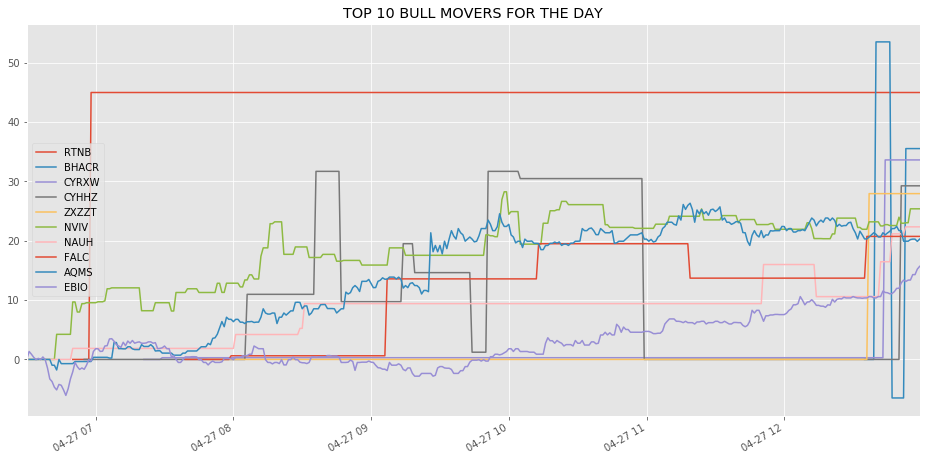

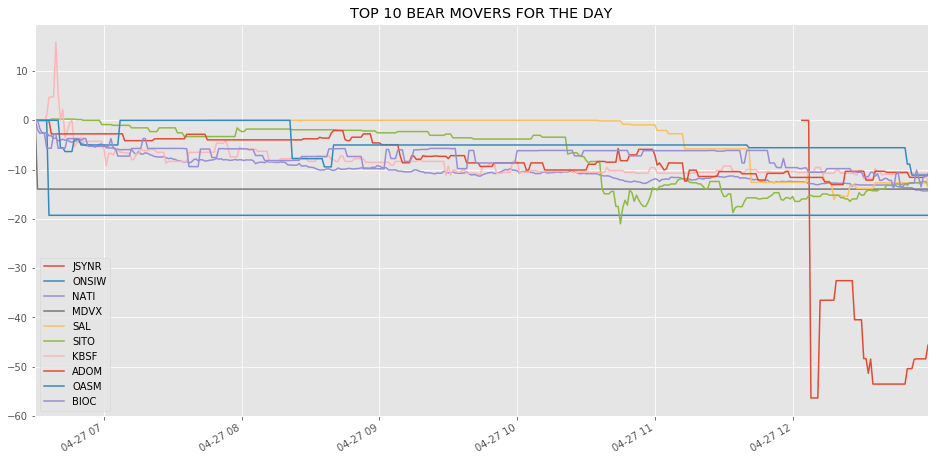

period 0:01:14.032613
SHOR {'chart': {'error': {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}, 'result': None}}
TCBIW {'chart': {'error': {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}, 'result': None}}
FMCIW {'chart': {'error': {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}, 'result': None}}
ANDAW {'chart': {'error': {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}, 'result': None}}
Exception while getiing AQMS HTTPSConnectionPool(host='query1.finance.yahoo.com', port=443): Max retries exceeded with url: /v7/finance/chart/AQMS?period1=1524835800&period2=1524867420&interval=1m&indicators=quote&includeTimestamps=true&events=div%7Csplit%7Cearn (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x7f5f217dd240>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))
Exception while ge

Exception while getiing FFBCW HTTPSConnectionPool(host='query1.finance.yahoo.com', port=443): Max retries exceeded with url: /v7/finance/chart/FFBCW?period1=1524835800&period2=1524867420&interval=1m&indicators=quote&includeTimestamps=true&events=div%7Csplit%7Cearn (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x7f5f217f0438>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))
ZXYZ.A {'chart': {'error': {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}, 'result': None}}


In [ ]:
prev_time = None

while True:
    # now = datetime.now(tz=CLIENT_TIMEZONE)
    start = datetime.now()
    
    if prev_time:
        seconds_since_update = (start - prev_time).seconds
        if seconds_since_update < 60:
            sleep(60 - seconds_since_update)    
    
    period_changes, minute_data = load_data(symbols, now)
    
    # calc bull&bear moves
    bull = {}
    bear = {}
    top_bull_movers = []
    top_bear_movers = []
    for p in periods:
        changes_bear = period_changes.sort_values(by=p)[:TOP_ITEMS_COUNT]        
        bear[p] = ["{} {:10.2f}%".format(i[0], i[1]) for i in changes_bear[[p]].itertuples()]       
         
        
        changes_bull = period_changes.sort_values(by=p, ascending=False)[:TOP_ITEMS_COUNT]         
        bull[p] = ["{} {:10.2f}%".format(i[0], i[1]) for i in changes_bull[[p]].itertuples()]
        
        if p == "All day":
            top_bear_movers = changes_bear.index.values
            top_bull_movers = changes_bull.index.values
    
    # create a table with accumulated changes percents
    changes = None
    for symbol in set(list(top_bull_movers) + list(top_bear_movers)):
        values = minute_data[symbol]
        first_v = next((v for v in values if not isnan(v)), None)
        if first_v:  
            # calculate cumulative changes
            changes_list = []
            prev_change = None
            for v in values:
                change = prev_change if isnan(v) else (v / first_v - 1) * 100
                changes_list.append(change)
                prev_change = change

            # push the changes to the table
            change_df = pd.DataFrame({symbol: changes_list}, values.index)
            if changes is None:
                changes = change_df
            else:
                changes = changes.join(change_df, how="outer")
            
    # display
    clear_output()
    
    display(HTML("<h4>Bull Movers</h4>"))
    bull = pd.DataFrame(bull)
    display(bull[periods]) 
    
    display(HTML("<h4>Bear Movers</h4>"))
    bear = pd.DataFrame(bear)
    display(bear[periods]) 
    
    if changes is not None:        
        changes[top_bull_movers].plot(figsize=(16, 8), title="TOP 10 BULL MOVERS FOR THE DAY")    
        changes[top_bear_movers].plot(figsize=(16, 8), title="TOP 10 BEAR MOVERS FOR THE DAY") 
        plt.show()    
    
    print("period", (datetime.now() - start))
    prev_time = start